# PMEL/FOCI ERDDAP for Moorings Example

## EcoFOCI Background

EcoFOCI maintains an internal server (or two) that mooring/ctd and other data is served up on.  downdraft/thundersnow is the test server (S.Bell's office) and Akutan is considered the production server (virtual linux system)

## ERDDAP References

more info can be found on the erddapy webpage - https://ioos.github.io/erddapy/quick_intro.html#

In [34]:
#standard imports for this operation
from erddapy import ERDDAP
import pandas as pd
import numpy as np

erddap has two types of data basically... gridded (foci data uses this for 1hr datasets and adcp data) and tabular.  Tabular imports to pandas very nicely as csv files and gridded imports to xarray (via .nc files) nicely.  Of course, more meta information is retained when importing a netcdf file than a csv file if this is important.

In [35]:
server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'
did = 'datasets_Mooring_19bsm2a_final'
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

#usally two data bases exist for each deployment, a preliminary and a final
#a gridded may also exist (build from the final tabular dataset) and an ADCP dataset may exist
d.dataset_id=did

#define the variables you want to get
d.variables =  [
 'timeseries_id',
 'Temperature',
 'Salinity',
 'Chlorophyll',
 'Turbidity',
 'latitude',
 'longitude',
 'depth',
 "time",
 'Oxy_Conc',
 'Oxy_Sat'
]

# useful if only wanting a small time portion
d.constraints = {
    'time>=': '2018-01-01T00:00:00Z',
    'time<=': '2020-10-10T00:00:00Z',
}

#data download below will fail unitl the variables are named apporpiatly

the following will get variable names by attribute "standard_name" where standard_name is not empty (useful as variables may have different names among datasets, but standard_names are pulled from the CF standard naming convention where available)

In [36]:
d.get_var_by_attr(dataset_id=did,standard_name='sea_water_temperature')

['temperature']

In [77]:
variables = d.get_var_by_attr(
        dataset_id=did,
        standard_name=lambda v: (v is not None)
    )


variables

['pressure',
 'Oxygen_Saturation',
 'Oxygen_Concentration',
 'latitude',
 'time',
 'Chlorophyll_Fluorescence',
 'depth',
 'temperature',
 'salinity',
 'longitude']

In [78]:
def show_iframe(src):
    """Helper function to show HTML returns."""
    from IPython.display import HTML
    iframe = f'<iframe src="{src}" width="100%" height="950"></iframe>'
    return HTML(iframe)

In [79]:
#watch out for deg E conversions - either >180 or <0
kw = {
    'standard_name': 'seawater_temperature',
    'min_lon': 180.0,
    'max_lon': 220.0,
    'min_lat': 50.0,
    'max_lat': 85.0,
}

search_url = d.get_search_url(response='html', **kw)

show_iframe(search_url)

erddapy really is just a url builder, the following url can be passed into just about any RESTful service

In [80]:
d.variables = variables
download_url = d.get_download_url()

from urllib.parse import urlencode
print(download_url) #not working?

http://downdraft.pmel.noaa.gov:8080/erddap/tabledap/datasets_Mooring_19bsm2a_final.csv?pressure,Oxygen_Saturation,Oxygen_Concentration,latitude,time,Chlorophyll_Fluorescence,depth,temperature,salinity,longitude&time>=1514764800.0&time<=1602288000.0


In [82]:
#download data
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
)

df.sort_index(inplace=True)
df.columns = [x[1].split()[0] for x in enumerate(df.columns)]

df.head()

,pressure,Oxygen_Saturation,Oxygen_Concentration,latitude,Chlorophyll_Fluorescence,depth,temperature,salinity,longitude
time (UTC),,,,,,,,,
2019-04-25 05:00:00+00:00,NaN,NaN,NaN,56.871166,NaN,55.0,3.6770,NaN,195.930145
2019-04-25 05:00:00+00:00,NaN,NaN,NaN,56.871166,2.815484,55.0,NaN,NaN,195.930145
2019-04-25 05:00:00+00:00,NaN,NaN,NaN,56.871166,NaN,15.0,3.6893,NaN,195.930145
2019-04-25 05:00:00+00:00,39.627,NaN,NaN,56.871166,NaN,39.0,3.6769,NaN,195.930145
2019-04-25 05:00:00+00:00,NaN,NaN,NaN,56.871166,NaN,9.0,3.7448,NaN,195.930145


In [83]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

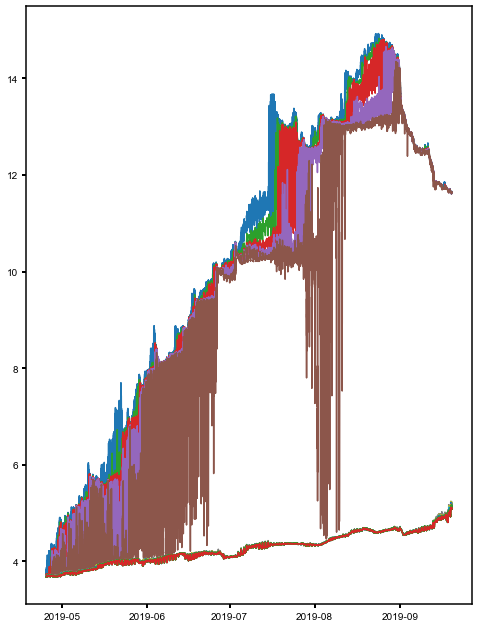

In [85]:
fig, ax = plt.subplots(figsize=(8, 11))
for name,group in df.groupby(df.depth):
    ax.plot(group.index,group.temperature)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


Text(0,0.5,'Depth (m)')

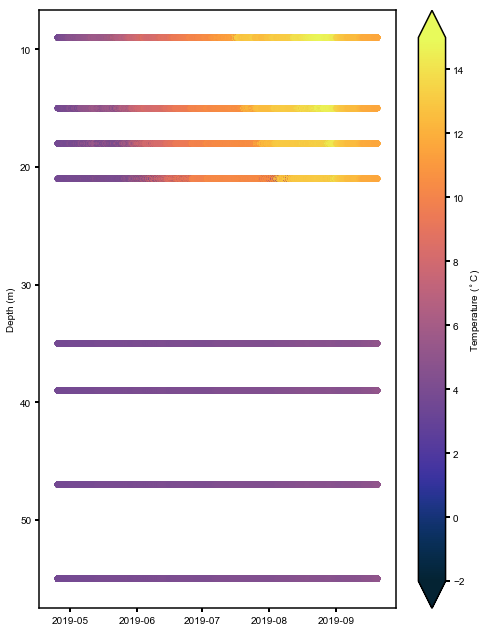

In [88]:
#not gridded
%time
fig, ax = plt.subplots(figsize=(8, 11))
for name,group in df.groupby(df.depth):
    cs = ax.scatter(group.index,group.depth,c=group.temperature,
              vmin=-2, vmax=15, marker='o', edgecolor='none', 
               cmap=cmocean.cm.thermal)
    
ax.invert_yaxis()
cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')

In [92]:
#the above is slow... is nc the way to go? doesn't seem so
d.response = 'nc'

download_url = d.get_download_url()

ds = d.to_xarray(decode_times=True)

ds

<xarray.Dataset>
Dimensions:                   (row: 751971)
Dimensions without coordinates: row
Data variables:
    depth                     (row) float32 ...
    Oxygen_Saturation         (row) float32 ...
    latitude                  (row) int8 ...
    sal                       (row) float32 ...
    Chlorophyll_Fluorescence  (row) float32 ...
    temp                      (row) float32 ...
    pres                      (row) float32 ...
    time                      (row) datetime64[ns] ...
    Oxygen_Concentration      (row) float32 ...
    longitude                 (row) float64 ...
Attributes:
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      timeseries_id, Instrument_Identifier, Seri...
    COMPOSITE:                     1
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    CREATION_DATE:                 January 08, 2020 23:31 UTC
    Easternmost_Easting:           195.93014526367188
    EPIC_FILE_GENERATOR:           nc_epic2udunits_time.py V0.4.0
    featureType:                   TimeSeries
    geospatial_lat_max:            57.0
    geospatial_lat_min:            57.0
    geospatial_lat_units:          degrees_north
    geospatial_lon_max:            195.93014526367188
    geospatial_lon_min:            195.93014526367188
    geospatial_lon_units:          degrees_east
    geospatial_vertical_max:       55.0
    geospatial_vertical_min:       9.0
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    history:                       2020-01-10T17:50:14Z (local files)\n2020-0...
    id:                            datasets_Mooring_19bsm2a_final
    infoUrl:                       https://pmel.noaa.gov/
    institution:                   PMEL
    keywords:                      active, C_50, channel, chemistry, chloroph...
    keywords_vocabulary:           GCMD Science Keywords
    license:                       The data may be used and redistributed for...
    MOORING:                       19bsm2a
    Northernmost_Northing:         57.0
    sourceUrl:                     (local files)
    Southernmost_Northing:         57.0
    standard_name_vocabulary:      CF Standard Name Table v55
    subsetVariables:               depth, latitude, longitude, pres, timeseri...
    summary:                       QC'd (final) data from 19BSM-2A
    time_coverage_end:             2019-09-20T00:00:00Z
    time_coverage_start:           2019-04-25T05:00:00Z
    title:                         19BSM-2A data
    WATER_DEPTH:                   71
    Westernmost_Easting:           195.93014526367188

one long timeseries - need to grid it to make it more useful though... so nc not really - not from tabular anyways...

so from the tabular data, I create a gridded product (easy to modify) set at 1hr intervals which are then hosted as grids on erddap with appropriate file modified for the name

In [86]:
dataset = '1hr_gridded_datasets_Mooring_19bsm2a_final'

e = ERDDAP(server=server_url)

e.constraints = None
e.protocol = 'griddap'

opendap_url = e.get_download_url(
    dataset_id=dataset,
    response='opendap',
)

print(opendap_url)

http://downdraft.pmel.noaa.gov:8080/erddap/griddap/1hr_gridded_datasets_Mooring_19bsm2a_final


In [87]:
from netCDF4 import Dataset

with Dataset(opendap_url) as nc:
    print(nc.summary)

QC'd (final) mooring data from 19BSM2A.  This dataset has been gridded to 1hr resolution (with pressure left at discrete depths).  It uses only datasets from the associated erddap tabular datasets_Mooring_19bsm2a_final


In [88]:
e.dataset_id=dataset
e.response = 'nc'
ds = e.to_xarray(decode_times=True)

/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'temperature' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  use_cftime=use_cftime,
/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pressure' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  use_cftime=use_cftime,
/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'salinity' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  use_cftime=use_cftime,
/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'PAR' has multiple fill values {1e+35, -9999.0}, decoding all values to NaN.
  use_cftime=use_cftime,
/Users/bell/anaconda2/envs/py37/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWa

In [89]:
ds

<xarray.Dataset>
Dimensions:                   (depth: 14, time: 3548)
Coordinates:
  * depth                     (depth) float64 9.0 11.0 12.0 ... 50.0 55.0 60.0
  * time                      (time) datetime64[ns] 2019-04-25T05:00:00 ... 2019-09-20
Data variables:
    latitude                  (depth, time) float64 ...
    longitude                 (depth, time) float64 ...
    temperature               (depth, time) float64 ...
    pressure                  (depth, time) float64 ...
    salinity                  (depth, time) float64 ...
    PAR                       (depth, time) float64 ...
    Chlorophyll_Fluorescence  (depth, time) float64 ...
    Oxygen_Saturation         (depth, time) float64 ...
    Oxygen_Concentration      (depth, time) float64 ...
    Serial_Number             (depth, time) float64 ...
Attributes:
    cdm_data_type:                 Grid
    Conventions:                   COARDS, CF-1.6, ACDD-1.3
    geospatial_vertical_max:       60.0
    geospatial_vertical_min:       9.0
    geospatial_vertical_positive:  down
    geospatial_vertical_units:     m
    history:                       2020-06-04T21:54:26Z (local files)\n2020-0...
    infoUrl:                       https://pmel.noaa.gov/
    institution:                   NOAA/PMEL - EcoFOCI
    keywords:                      active, available, chemistry, chlorophyll,...
    keywords_vocabulary:           GCMD Science Keywords
    license:                       The data may be used and redistributed for...
    sourceUrl:                     (local files)
    standard_name_vocabulary:      CF Standard Name Table v55
    summary:                       QC'd (final) mooring data from 19BSM2A.  T...
    time_coverage_end:             2019-09-20T00:00:00Z
    time_coverage_start:           2019-04-25T05:00:00Z
    title:                         Gridded Mooring Data from 19BSM2A - final

much more useful as it is geophysically gridded along time/depth

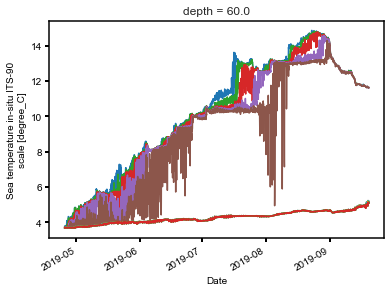

In [98]:
for i in range(0,len(ds.temperature)):
    ds.temperature[i].plot()

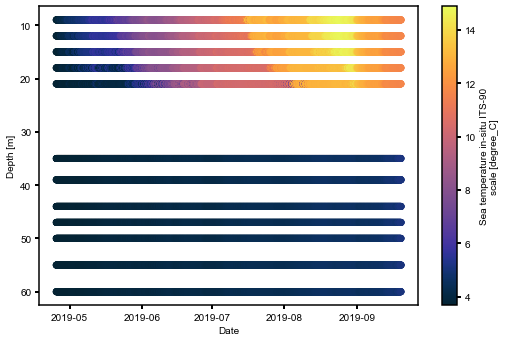

In [151]:
fig, (ax1) = plt.subplots(nrows=1, sharex=True, figsize=(8.5,5.5))
ds.plot.scatter(x='time',y='depth',hue='temperature', cmap=cmocean.cm.thermal, ax=ax1)
ax1.invert_yaxis()


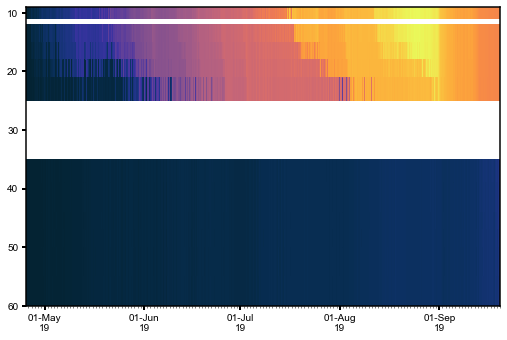

In [93]:
#or better yet
fig, (ax1) = plt.subplots(nrows=1, sharex=True, figsize=(8.5,5.5))

ax1.pcolormesh(ds.time,ds.depth,ds.temperature,
                     cmap=cmocean.cm.thermal)

ax1.invert_yaxis()


xfmt = mdates.DateFormatter('%d-%b\n%y')
ax1.xaxis.set_major_formatter(xfmt)
ax1.xaxis.set_major_locator(MonthLocator())
ax1.xaxis.set_minor_locator(DayLocator())
